In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
df_all = pd.read_csv('fully_processed_stock_data.csv', parse_dates=['Date'])

SECTORS = {
    "Tech_Growth": [
        'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'AVGO', 'CRM', 'AMD', '^IXIC'
    ],
    "Stable_Defensive": [
        'JPM', 'V', 'MA', 'BAC', 'GS',       
        'UNH', 'JNJ', 'LLY', 'PFE', 'MRK',   
        'WMT', 'PG', 'COST', 'HD', 'NKE',  
        '^DJI'
    ],
    "Macro_Indices": ['^GSPC'] 
}

print("Engineering features (Horizons: 2, 5, 60, 250)...")

Engineering features (Horizons: 2, 5, 60, 250)...


In [3]:
def engineer_features_sector(group):
    group = group.sort_values('Date')
    
    group["Tomorrow"] = group["Close"].shift(-1)
    group["Target"] = (group["Tomorrow"] > group["Close"]).astype(int)
    
    horizons = [2, 5, 60, 250]
    
    for horizon in horizons:
        rolling = group["Close"].rolling(horizon).mean()
        group[f"Close_Ratio_{horizon}"] = group["Close"] / rolling
        
        group[f"Trend_{horizon}"] = group["Target"].shift(1).rolling(horizon).sum()
        
    return group.dropna()

df_grouped = df_all.groupby('Ticker', group_keys=False).apply(engineer_features_sector)
df_combined = df_grouped.sort_values('Date').set_index('Date')

predictors = [c for c in df_combined.columns if "Ratio" in c or "Trend" in c]
print(f"Total Data Available: {df_combined.shape} (Significantly increased)")


Total Data Available: (57204, 54) (Significantly increased)


C:\Users\Karan\AppData\Local\Temp\ipykernel_18024\617568648.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df_all.groupby('Ticker', group_keys=False).apply(engineer_features_sector)


In [4]:
def create_sector_sequences(df, predictors, time_steps=60):
    Xs, ys = [], []
    scaler = StandardScaler()
    scaler.fit(df[predictors])
    
    for ticker in df['Ticker'].unique():
        ticker_df = df[df['Ticker'] == ticker]
        if len(ticker_df) < time_steps: continue
            
        data = scaler.transform(ticker_df[predictors])
        target = ticker_df["Target"].values
        
        for i in range(len(data) - time_steps):
            Xs.append(data[i:(i + time_steps)])
            ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys), scaler


In [5]:
results = []

for sector_name, tickers in SECTORS.items():
    print(f"\n{'='*40}")
    print(f"TRAINING SECTOR: {sector_name} ({len(tickers)} tickers)")
    print(f"{'='*40}")
    
    sector_df = df_combined[df_combined['Ticker'].isin(tickers)].copy()
    
    if sector_df.empty:
        print(f"No data found for {sector_name}, skipping.")
        continue

    dates = sector_df.index.unique().sort_values()
    split_idx = int(len(dates) * 0.8)
    split_date = dates[split_idx]
    
    train = sector_df[sector_df.index < split_date]
    test = sector_df[sector_df.index >= split_date]
    
    print(f"Train size: {len(train)} | Test size: {len(test)}")
    
    scaler_std = StandardScaler()
    X_train = scaler_std.fit_transform(train[predictors])
    y_train = train["Target"]
    X_test = scaler_std.transform(test[predictors])
    y_test = test["Target"]
    
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    p_lr = precision_score(y_test, lr.predict(X_test), zero_division=0)
    
    if len(X_train) > 30000:
        svm = SVC(cache_size=1000)
        svm.fit(X_train[:30000], y_train[:30000])
    else:
        svm = SVC()
        svm.fit(X_train, y_train)
    p_svm = precision_score(y_test, svm.predict(X_test), zero_division=0)
    
    rf = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1, n_jobs=-1)
    rf.fit(train[predictors], y_train) 
    probs_rf = rf.predict_proba(test[predictors])[:,1]
    preds_rf = (probs_rf >= 0.6).astype(int)
    p_rf = precision_score(y_test, preds_rf, zero_division=0)
    
    print(f"Training {sector_name} LSTM...")
    X_train_seq, y_train_seq, _ = create_sector_sequences(train, predictors)
    X_test_seq, y_test_seq, _ = create_sector_sequences(test, predictors)
    
    if len(X_train_seq) > 0:
        model_lstm = Sequential()
        model_lstm.add(Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        model_lstm.add(LSTM(50, return_sequences=True))
        model_lstm.add(Dropout(0.2))
        model_lstm.add(LSTM(50))
        model_lstm.add(Dropout(0.2))
        model_lstm.add(Dense(1, activation='sigmoid'))
        model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        epochs = 8 if len(X_train_seq) > 5000 else 15
        model_lstm.fit(X_train_seq, y_train_seq, batch_size=64, epochs=epochs, verbose=0)
        
        probs_lstm = model_lstm.predict(X_test_seq, verbose=0)
        preds_lstm = (probs_lstm > 0.5).astype(int).flatten()
        p_lstm = precision_score(y_test_seq, preds_lstm, zero_division=0)
    else:
        p_lstm = 0.0

    results.append({
        "Sector": sector_name,
        "Weight": len(tickers),

        "y_test": y_test.values,
        "pred_lr": lr.predict(X_test),
        "pred_svm": svm.predict(X_test),
        "pred_rf": preds_rf,

        "y_test_seq": y_test_seq if p_lstm > 0 else None,
        "pred_lstm": preds_lstm if p_lstm > 0 else None
    })

    
    print(f"Done. RF Precision: {p_rf:.4f}")


TRAINING SECTOR: Tech_Growth (11 tickers)
Train size: 17974 | Test size: 4499
Training Tech_Growth LSTM...
Done. RF Precision: 0.6258

TRAINING SECTOR: Stable_Defensive (16 tickers)
Train size: 26144 | Test size: 6544
Training Stable_Defensive LSTM...
Done. RF Precision: 0.5820

TRAINING SECTOR: Macro_Indices (1 tickers)
Train size: 1634 | Test size: 409
Training Macro_Indices LSTM...
Done. RF Precision: 0.4231


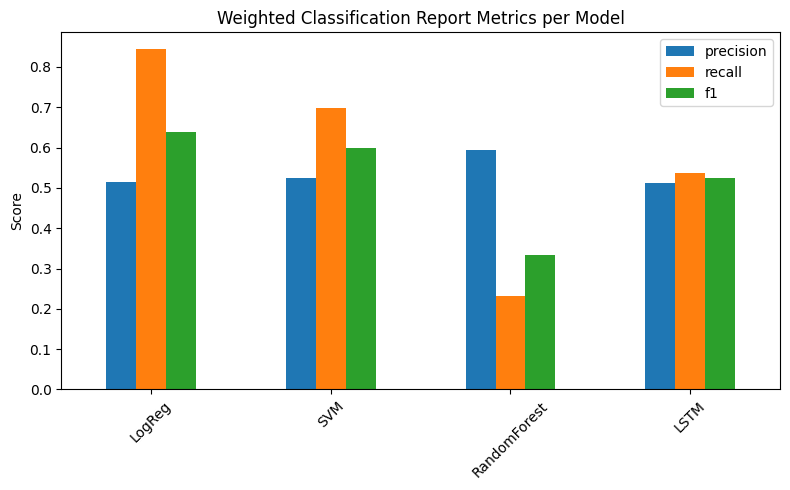

In [6]:
final_reports = {m: {"precision":0, "recall":0, "f1":0} for m in ["LogReg","SVM","RandomForest","LSTM"]}
total_weight = 0

for r in results:
    w = r["Weight"]
    total_weight += w

    rep_lr = classification_report(r["y_test"], r["pred_lr"], output_dict=True, zero_division=0)
    final_reports["LogReg"]["precision"] += rep_lr["1"]["precision"] * w
    final_reports["LogReg"]["recall"] += rep_lr["1"]["recall"] * w
    final_reports["LogReg"]["f1"] += rep_lr["1"]["f1-score"] * w

    rep_svm = classification_report(r["y_test"], r["pred_svm"], output_dict=True, zero_division=0)
    final_reports["SVM"]["precision"] += rep_svm["1"]["precision"] * w
    final_reports["SVM"]["recall"] += rep_svm["1"]["recall"] * w
    final_reports["SVM"]["f1"] += rep_svm["1"]["f1-score"] * w

    rep_rf = classification_report(r["y_test"], r["pred_rf"], output_dict=True, zero_division=0)
    final_reports["RandomForest"]["precision"] += rep_rf["1"]["precision"] * w
    final_reports["RandomForest"]["recall"] += rep_rf["1"]["recall"] * w
    final_reports["RandomForest"]["f1"] += rep_rf["1"]["f1-score"] * w

    if r["y_test_seq"] is not None:
        rep_lstm = classification_report(r["y_test_seq"], r["pred_lstm"], output_dict=True, zero_division=0)
        final_reports["LSTM"]["precision"] += rep_lstm["1"]["precision"] * w
        final_reports["LSTM"]["recall"] += rep_lstm["1"]["recall"] * w
        final_reports["LSTM"]["f1"] += rep_lstm["1"]["f1-score"] * w

for m in final_reports:
    final_reports[m]["precision"] /= total_weight
    final_reports[m]["recall"] /= total_weight
    final_reports[m]["f1"] /= total_weight

import pandas as pd
import matplotlib.pyplot as plt

df_plot = pd.DataFrame(final_reports).T

df_plot.plot(kind="bar", figsize=(8,5))
plt.ylabel("Score")
plt.title("Weighted Classification Report Metrics per Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Training on device: cpu

Training HF Transformer for: Tech_Growth...
  Train samples: 17259, Test samples: 3784
  Input shape: torch.Size([17259, 65, 11])
  Epoch 5/15, Loss: 0.6923
  Epoch 10/15, Loss: 0.6909
  Epoch 15/15, Loss: 0.6858
  > HF Transformer Precision: 0.5013

Training HF Transformer for: Stable_Defensive...
  Train samples: 25104, Test samples: 5504
  Input shape: torch.Size([25104, 65, 11])
  Epoch 5/15, Loss: 0.6881
  Epoch 10/15, Loss: 0.6849
  Epoch 15/15, Loss: 0.6785
  > HF Transformer Precision: 0.4986

Training HF Transformer for: Macro_Indices...
  Train samples: 1569, Test samples: 344
  Input shape: torch.Size([1569, 65, 11])
  Epoch 5/15, Loss: 0.6920
  Epoch 10/15, Loss: 0.6920
  Epoch 15/15, Loss: 0.6920
  > HF Transformer Precision: 0.5203

SECTOR-WISE HF TRANSFORMER CLASSIFICATION REPORTS

--- Tech_Growth ---
              precision    recall  f1-score   support

           0       0.45      0.34      0.39      1821
           1       0.50      0.61     

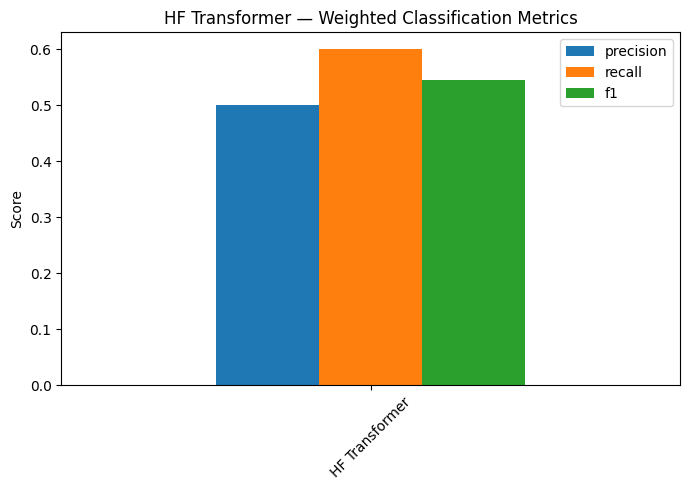

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

class HF_TimeSeriesClassifier(nn.Module):
    def __init__(self, input_features, context_length=60):
        super().__init__()
        
        self.context_length = context_length
        self.lags_sequence = [1, 2, 3, 4, 5]
        self.past_length = context_length + max(self.lags_sequence)
        
        self.config = TimeSeriesTransformerConfig(
            prediction_length=1,
            context_length=context_length,
            input_size=input_features,
            lags_sequence=self.lags_sequence,
            num_time_features=1,
            d_model=64,
            encoder_layers=2,
            decoder_layers=2,
            encoder_attention_heads=4,
            decoder_attention_heads=4,
            dropout=0.2,
            scaling=True
        )
        
        self.transformer = TimeSeriesTransformerForPrediction(self.config)
        
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, past_values, past_time_features):
        batch_size = past_values.shape[0]
        num_features = past_values.shape[2]
        
        past_observed_mask = torch.ones(
            batch_size, self.past_length, num_features,
            device=past_values.device, dtype=torch.bool
        )
        
        future_values = torch.zeros(
            batch_size, 1, num_features, 
            device=past_values.device, dtype=past_values.dtype
        )
        future_time_features = torch.zeros(
            batch_size, 1, 1,
            device=past_values.device, dtype=past_values.dtype
        )
        
        outputs = self.transformer.model(
            past_values=past_values,
            past_time_features=past_time_features,
            past_observed_mask=past_observed_mask,
            future_values=future_values,
            future_time_features=future_time_features,
            output_hidden_states=True
        )
        
        encoder_last_hidden = outputs.encoder_last_hidden_state
        pooled = encoder_last_hidden.mean(dim=1) 
        
        return self.classifier(pooled)

def create_sequences(df, predictors, scaler, context_length=60, lags_sequence=[1,2,3,4,5]):
    past_length = context_length + max(lags_sequence)
    Xs, ys, time_feats = [], [], []
    
    for ticker in df['Ticker'].unique():
        ticker_df = df[df['Ticker'] == ticker]
        if len(ticker_df) < past_length:
            continue
        
        data = scaler.transform(ticker_df[predictors])
        target = ticker_df["Target"].values
        time_idx = np.arange(len(data))
        
        for i in range(len(data) - past_length):
            Xs.append(data[i:(i + past_length)])
            ys.append(target[i + past_length])
            
            time_seq = time_idx[i:(i + past_length)]
            time_seq_norm = (time_seq - time_seq.min()) / (time_seq.max() - time_seq.min() + 1e-8)
            time_feats.append(time_seq_norm.reshape(-1, 1))
    
    return (
        torch.tensor(np.array(Xs), dtype=torch.float32), 
        torch.tensor(np.array(time_feats), dtype=torch.float32),
        torch.tensor(np.array(ys), dtype=torch.float32).unsqueeze(1)
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

for sector_name, tickers in SECTORS.items():
    print(f"\nTraining HF Transformer for: {sector_name}...")
    
    sector_df = df_combined[df_combined['Ticker'].isin(tickers)].copy()
    if sector_df.empty:
        continue

    dates = sector_df.index.unique().sort_values()
    split_date = dates[int(len(dates) * 0.8)]
    
    train_df = sector_df[sector_df.index < split_date]
    test_df = sector_df[sector_df.index >= split_date]
    
    scaler = StandardScaler()
    scaler.fit(train_df[predictors])
    
    X_train, T_train, y_train = create_sequences(train_df, predictors, scaler)
    X_test, T_test, y_test = create_sequences(test_df, predictors, scaler)
    
    if len(X_train) == 0:
        final_results[sector_name]["HF_Transf"] = 0.0
        continue

    print(f"  Train samples: {len(X_train)}, Test samples: {len(X_test)}")
    print(f"  Input shape: {X_train.shape}")
    train_loader = DataLoader(
        TensorDataset(X_train, T_train, y_train), 
        batch_size=64, 
        shuffle=True
    )
    
    model = HF_TimeSeriesClassifier(input_features=len(predictors)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    criterion = nn.BCELoss()
    
    model.train()
    epochs = 15
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_t, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_t = batch_t.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            predictions = model(batch_x, batch_t)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
            
    model.eval()
    with torch.no_grad():
        X_test_dev = X_test.to(device)
        T_test_dev = T_test.to(device)
        preds_prob = model(X_test_dev, T_test_dev).cpu().numpy()
        preds_binary = (preds_prob > 0.5).astype(int).flatten()
        
    score = precision_score(y_test.numpy(), preds_binary, zero_division=0)
    final_results[sector_name]["HF_Transf"] = score
    final_results[sector_name]["y_test_hf"] = y_test.numpy().astype(int)
    final_results[sector_name]["pred_hf"] = preds_binary.astype(int)

    print(f"  > HF Transformer Precision: {score:.4f}")
    
    
hf_sector_reports = {}
hf_weighted_sum = {"precision":0, "recall":0, "f1":0}
hf_total_weight = 0

print("\n" + "="*60)
print("SECTOR-WISE HF TRANSFORMER CLASSIFICATION REPORTS")
print("="*60)

for sector_name, tickers in SECTORS.items():

    if sector_name not in final_results or "HF_Transf" not in final_results[sector_name]:
        continue
    
    y_true = final_results[sector_name]["y_test_hf"]
    y_pred = final_results[sector_name]["pred_hf"]

    report = classification_report(
        y_true, y_pred, output_dict=True, zero_division=0
    )

    hf_sector_reports[sector_name] = report

    print(f"\n--- {sector_name} ---")
    print(classification_report(y_true, y_pred, zero_division=0))
    w = len(tickers)
    hf_total_weight += w

    hf_weighted_sum["precision"] += report["1"]["precision"] * w
    hf_weighted_sum["recall"] += report["1"]["recall"] * w
    hf_weighted_sum["f1"] += report["1"]["f1-score"] * w

hf_weighted_final = {
    m: hf_weighted_sum[m] / hf_total_weight
    for m in hf_weighted_sum
}

print("\n" + "="*60)
print("FINAL WEIGHTED AVERAGE (HF TRANSFORMER)")
print("="*60)
for metric, value in hf_weighted_final.items():
    print(f"{metric.capitalize():10s}: {value:.4f}")

df_hf_plot = pd.DataFrame({
    "HF Transformer": hf_weighted_final
}).T 

df_hf_plot.plot(kind="bar", figsize=(7,5))
plt.title("HF Transformer — Weighted Classification Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
print(final_reports)

{'LogReg': {'precision': 0.5153979659251727, 'recall': 0.8437664338130609, 'f1': 0.6385096434562226}, 'SVM': {'precision': 0.5239930715529185, 'recall': 0.6980886938337292, 'f1': 0.5984678658490983}, 'RandomForest': {'precision': 0.593537386294653, 'recall': 0.232845000021787, 'f1': 0.33345586726880805}, 'LSTM': {'precision': 0.518702446188578, 'recall': 0.5471481823109328, 'f1': 0.5320398465466063}}
